181 79 36 48
38 37 141 88


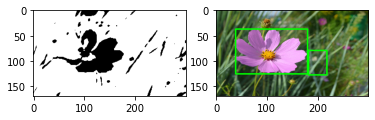

In [28]:
import cv2
import pickle
import matplotlib.pyplot as plt

#画像を読み込んでリサイズ
img=cv2.imread("cosmos-flower.jpg")
img=cv2.resize(img,(300,169))#300*169ピクセルにリサイズ

#色空間を二値化
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray=cv2.GaussianBlur(gray,(7,7),0)#画像の平滑化→細かい模様などを検出しないようにあえて荒くする
im2=cv2.threshold(gray,140,240,cv2.THRESH_BINARY_INV)[1]#実際に二値化
#threshold(グレースケール画像、閾値、閾値以上の値に割り当てる値、どのように二値化するか)

#画面左側に二値化した画像を描画
plt.subplot(1,2,1)
plt.imshow(im2,cmap="gray")

#輪郭を抽出
cnts=cv2.findContours(im2,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[0]
#findContours(入力画像、抽出モード、近似手法)
#抽出した枠を描画
for pt in cnts:
    x,y,w,h=cv2.boundingRect(pt)
    #大きすぎたり小さすぎる領域を除去
    if w<30 or w>200:continue
    print(x,y,w,h)#結果を出力
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

#画面右側に抽出結果を描画
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.savefig("find_contours.png",dpi=200)
plt.show()

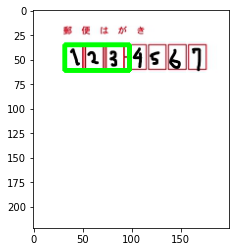

In [26]:
import cv2
import matplotlib.pyplot as plt


#はがき画像から郵便番号領域を抽出する関数
def detect_zipno(fname):
    #画像読み込み
    img=cv2.imread(fname)
    #画像のサイズを求める
    h,w=img.shape[:2]
    #はがき画像の右上のみ抽出する
    img=img[0:h//2,w//3:]
    
    #画像を二値化
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray=cv2.GaussianBlur(gray,(3,3),0)
    im2=cv2.threshold(gray,140,255,cv2.THRESH_BINARY_INV)[1]
    
    #輪郭を抽出
    cnts=cv2.findContours(im2,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[0]
    
    #抽出した輪郭を単純なリストに変換
    result=[]
    for pt in cnts:
        x,y,w,h=cv2.boundingRect(pt)
        #大きすぎる小さすぎる領域を除去
        if not(50<w<70):continue
        result.append([x,y,w,h])
    #抽出した輪郭が左側から並ぶようソート
    result=sorted(result,key=lambda x: x[0])
    #抽出した輪郭が小さすぎるものを除去
    result2=[]
    lastx=-100
    for x,y,w,h in result:
        if(x - lastx)<40:continue
        result2.append([x,y,w,h])
        lastx=x
    #緑色の枠を描画
    for x,y,w,h in result2:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
    return result2,img

if __name__=='__main__':
    #はがき画像を指定して領域を抽出
    cnts,img=detect_zipno("hagaki2.png")
    
    #画面に抽出結果を描画
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.savefig("detect-zip.png",dpi=200)
    plt.show()

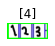

In [45]:
import matplotlib.pyplot as plt
import pickle

def detect_zipno(fname):
    #画像読み込み
    img=cv2.imread(fname)
    #画像のサイズを求める
    h,w=img.shape[:2]
    #はがき画像の右上のみ抽出する
    img=img[0:h//2,w//3:]
    
    #画像を二値化
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray=cv2.GaussianBlur(gray,(3,3),0)
    im2=cv2.threshold(gray,140,255,cv2.THRESH_BINARY_INV)[1]
    
    #輪郭を抽出
    cnts=cv2.findContours(im2,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[0]
    
    #抽出した輪郭を単純なリストに変換
    result=[]
    for pt in cnts:
        x,y,w,h=cv2.boundingRect(pt)
        #大きすぎる小さすぎる領域を除去
        if not(50<w<70):continue
        result.append([x,y,w,h])
    #抽出した輪郭が左側から並ぶようソート
    result=sorted(result,key=lambda x: x[0])
    #抽出した輪郭が小さすぎるものを除去
    result2=[]
    lastx=-100
    for x,y,w,h in result:
        if(x - lastx)<40:continue
        result2.append([x,y,w,h])
        lastx=x
    #緑色の枠を描画
    for x,y,w,h in result2:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
    return result2,img

#学習済み手書き数字のデータを読み込む
with open("digits.pkl","rb") as fp:
    clf=pickle.load(fp)

#画像から領域を読み込む
cnts,img=detect_zipno("hagaki2.png")

#読み込んだデータをプロット
for i, pt in enumerate(cnts):
    x,y,w,h=pt
    #枠線の輪郭分だけ小さくする
    x+=8
    y+=8
    w-=16
    h-=16
    #画像データを取り出す
    im2=img[y:y+h,x:x+w]
    #データを学習済みデータに合わせる
    im2gray=cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)#グレースケールに変換
    im2gray=cv2.resize(im2gray,(8,8))#リサイズ
    im2gray=15-im2gray//16#白黒反転
    im2gray=im2gray.reshape((-1,64))#一次元に変換
    #データを予測
    res=clf.predict(im2gray)
    #画面に出力
    plt.subplot(1,7,i+1)
    plt.imshow(im2)
    plt.axis("off")
    plt.title(str(res))
plt.show()